# Handling instability in non-smooth functions

In [1]:
%pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import matplotlib.pyplot as plt

import pybamm

Note: you may need to restart the kernel to use updated packages.


## Handling instabilities

### Smooth approximations to non-differentiable functions

Some functions, such as `minimum`, `maximum`, `heaviside`, and `abs`, are discontinuous and/or non-differentiable (their derivative is discontinuous). Adaptive solvers can deal with this discontinuity, but will take many more steps close to the discontinuity in order to resolve it. Therefore, using soft approximations instead can reduce the number of steps taken by the solver, and hence the integration time. See [this post](https://discourse.julialang.org/t/handling-instability-when-solving-ode-problems/9019/5) for more details.

Here is an example using the `maximum` function. The function `maximum(x,1)` is continuous but non-differentiable at `x=1`, where its derivative jumps from 0 to 1. However, we can approximate it using the [`softplus` function](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)#Softplus), which is smooth everywhere and is sometimes used in neural networks as a smooth approximation to the RELU activation function. The `softplus` function is given by
$$
s(x,y;k) = \frac{\log(\exp(kx)+\exp(ky))}{k},
$$
where `k` is a strictly positive smoothing (or sharpness) parameter. The larger the value of `k`, the better the approximation but the stiffer the term (exp blows up quickly!). Usually, a value of `k=10` is a good middle ground.

In PyBaMM, you can either call the `softplus` function directly, or change `pybamm.settings.max_smoothing` to automatically replace all your calls to `pybamm.maximum` with `softplus`.

In [2]:
x = pybamm.Variable("x")
y = pybamm.Variable("y")

# Normal maximum
print(f"Exact maximum: {pybamm.maximum(x, y)}")

# Softplus
print("Softplus (k=10): ", pybamm.softplus(x, y, 10))

# Changing the setting to call softplus automatically
pybamm.settings.min_max_mode = "soft"
pybamm.settings.min_max_smoothing = 20
print(f"Softplus (k=20): {pybamm.maximum(x, y)}")

# All smoothing parameters can be changed at once
pybamm.settings.set_smoothing_parameters(30)
print(f"Softplus (k=30): {pybamm.maximum(x, y)}")

# Change back
pybamm.settings.set_smoothing_parameters("exact")
print(f"Exact maximum: {pybamm.maximum(x, y)}")

Exact maximum: maximum(x, y)
Softplus (k=10):  0.1 * log(exp(10.0 * x) + exp(10.0 * y))
Softplus (k=20): 0.05 * log(exp(20.0 * x) + exp(20.0 * y))
Softplus (k=30): 0.03333333333333333 * log(exp(30.0 * x) + exp(30.0 * y))
Exact maximum: maximum(x, y)


Note that if both sides are constant then pybamm will use the exact value even if the setting is set to smoothing

In [3]:
a = pybamm.InputParameter("a")
pybamm.settings.max_smoothing = 20
# Both inputs are constant so uses exact maximum
print("Exact:", pybamm.maximum(0.999, 1).evaluate())
# One input is not constant (InputParameter) so uses softplus
print("Softplus:", pybamm.maximum(a, 1).evaluate(inputs={"a": 0.999}))
pybamm.settings.set_smoothing_parameters("exact")

Exact: 1.0
Softplus: 1.0


Here is the plot of softplus with different values of `k`

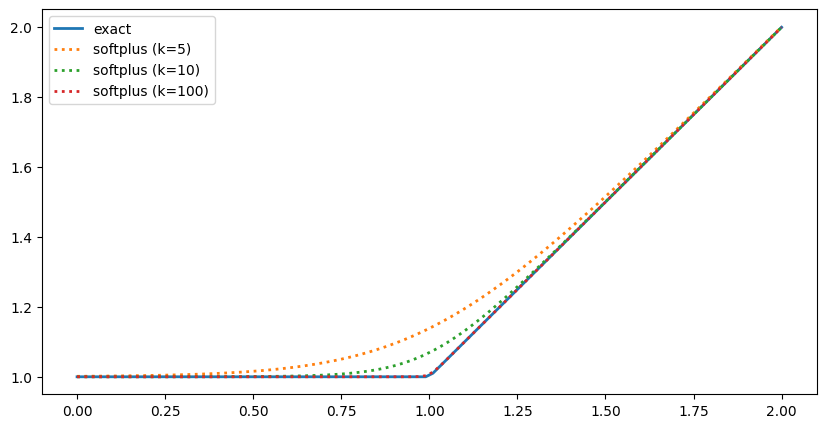

In [4]:
pts = pybamm.linspace(0, 2, 100)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pts.evaluate(), pybamm.maximum(pts, 1).evaluate(), lw=2, label="exact")
ax.plot(
    pts.evaluate(),
    pybamm.softplus(pts, 1, 5).evaluate(),
    ":",
    lw=2,
    label="softplus (k=5)",
)
ax.plot(
    pts.evaluate(),
    pybamm.softplus(pts, 1, 10).evaluate(),
    ":",
    lw=2,
    label="softplus (k=10)",
)
ax.plot(
    pts.evaluate(),
    pybamm.softplus(pts, 1, 100).evaluate(),
    ":",
    lw=2,
    label="softplus (k=100)",
)
ax.legend();

Solving a model with the exact maximum and soft approximation, demonstrates a clear speed-up even for a very simple model

In [5]:
model_exact = pybamm.BaseModel()
model_exact.rhs = {x: pybamm.maximum(x, 1)}
model_exact.initial_conditions = {x: 0.5}
model_exact.variables = {"x": x, "max(x,1)": pybamm.maximum(x, 1)}

model_smooth = pybamm.BaseModel()
k = pybamm.InputParameter("k")
model_smooth.rhs = {x: pybamm.softplus(x, 1, k)}
model_smooth.initial_conditions = {x: 0.5}
model_smooth.variables = {"x": x, "max(x,1)": pybamm.softplus(x, 1, k)}


# Exact solution
timer = pybamm.Timer()
time = 0
solver = pybamm.IDAKLUSolver()
for _ in range(100):
    exact_sol = solver.solve(model_exact, [0, 2])
    # Report integration time, which is the time spent actually doing the integration
    time += exact_sol.integration_time
print("Exact:", time / 100)
sols = [exact_sol]

ks = [5, 10, 100]
solver = pybamm.IDAKLUSolver()
for k in ks:
    time = 0
    for _ in range(100):
        sol = solver.solve(model_smooth, [0, 2], inputs={"k": k})
        time += sol.integration_time
    print(f"Soft, k={k}:", time / 100)
    sols.append(sol)

pybamm.dynamic_plot(
    sols, ["x", "max(x,1)"], labels=["exact"] + [f"soft (k={k})" for k in ks]
);

Exact: 75.264 us
Soft, k=5: 53.997 us
Soft, k=10: 58.327 us
Soft, k=100: 65.963 us


interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.02), Output()), _dom_classes=('w…

For the minimum and maximum functions, an alternative smoothing functions (smooth_max, smooth_min) are provided.
$$
 \textrm{min}(x, y) = 0.5 * (\sqrt((x - y)^2 + \sigma) + (x + y))
 \quad , \quad
 \textrm{max}(x, y) = 0.5 * ((x + y) - \sqrt((x - y)^2 + \sigma))
$$
where
$$
 \sigma = \frac{1}{k^2}
$$
For the smooth minimum and maximum functions, the recommended value of k is 100, where the function closely approximates the exact function, but is differentiable.

Changing between the soft, smooth, and exact functions can be done by setting the `min_max_mode` and the value of `k` stored in `min_max_smoothing`

In [6]:
x = pybamm.Variable("x")
y = pybamm.Variable("y")

# Normal maximum
print(f"Exact maximum: {pybamm.maximum(x, y)}")

# Smooth plus can be called explicitly
print("Smooth plus (k=100): ", pybamm.smooth_max(x, y, 100))

# Smooth plus and smooth minus will be used when the mode is set to "smooth"
pybamm.settings.min_max_mode = "smooth"
pybamm.settings.min_max_smoothing = 200
print(f"Smooth plus (k=200): {pybamm.maximum(x, y)}")

# Setting the smoothing parameters with set_smoothing_parameters() defaults to softplus
pybamm.settings.set_smoothing_parameters(10)
print(f"Softplus (k=10): {pybamm.maximum(x, y)}")

# Change back
pybamm.settings.set_smoothing_parameters("exact")
print(f"Exact maximum: {pybamm.maximum(x, y)}")

Exact maximum: maximum(x, y)
Smooth plus (k=100):  0.5 * (sqrt(0.0001 + (x - y) ** 2.0) + x + y)
Smooth plus (k=200): 0.5 * (sqrt(2.5e-05 + (x - y) ** 2.0) + x + y)
Softplus (k=10): 0.1 * log(exp(10.0 * x) + exp(10.0 * y))
Exact maximum: maximum(x, y)


Here is the plot of smooth_max with different values of `k`

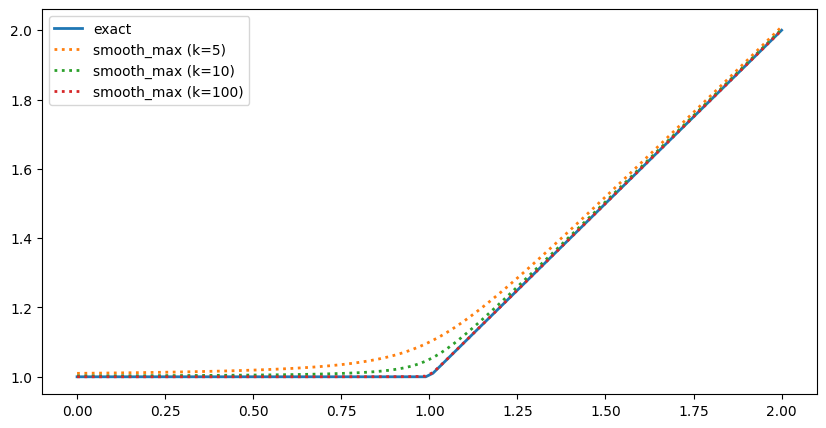

In [7]:
pts = pybamm.linspace(0, 2, 100)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pts.evaluate(), pybamm.maximum(pts, 1).evaluate(), lw=2, label="exact")
ax.plot(
    pts.evaluate(),
    pybamm.smooth_max(pts, 1, 5).evaluate(),
    ":",
    lw=2,
    label="smooth_max (k=5)",
)
ax.plot(
    pts.evaluate(),
    pybamm.smooth_max(pts, 1, 10).evaluate(),
    ":",
    lw=2,
    label="smooth_max (k=10)",
)
ax.plot(
    pts.evaluate(),
    pybamm.smooth_max(pts, 1, 100).evaluate(),
    ":",
    lw=2,
    label="smooth_max (k=100)",
)
ax.legend();

Solving a model with the exact maximum and smooth approximation, demonstrates a clear speed-up even for a very simple model

In [8]:
model_exact = pybamm.BaseModel()
model_exact.rhs = {x: pybamm.maximum(x, 1)}
model_exact.initial_conditions = {x: 0.5}
model_exact.variables = {"x": x, "max(x,1)": pybamm.maximum(x, 1)}

model_smooth = pybamm.BaseModel()
k = pybamm.InputParameter("k")
model_smooth.rhs = {x: pybamm.smooth_max(x, 1, k)}
model_smooth.initial_conditions = {x: 0.5}
model_smooth.variables = {"x": x, "max(x,1)": pybamm.smooth_max(x, 1, k)}


# Exact solution
timer = pybamm.Timer()
time = 0
solver = pybamm.IDAKLUSolver()
for _ in range(100):
    exact_sol = solver.solve(model_exact, [0, 2])
    # Report integration time, which is the time spent actually doing the integration
    time += exact_sol.integration_time
print("Exact:", time / 100)
sols = [exact_sol]

ks = [10, 50, 100, 1000, 10000]
solver = pybamm.IDAKLUSolver()
for k in ks:
    time = 0
    for _ in range(100):
        sol = solver.solve(model_smooth, [0, 2], inputs={"k": k})
        time += sol.integration_time
    print(f"Smooth, k={k}:", time / 100)
    sols.append(sol)

pybamm.dynamic_plot(
    sols, ["x", "max(x,1)"], labels=["exact"] + [f"soft (k={k})" for k in ks]
);

Exact: 70.677 us
Smooth, k=10: 66.839 us
Smooth, k=50: 63.669 us
Smooth, k=100: 63.810 us
Smooth, k=1000: 62.608 us
Smooth, k=10000: 63.784 us


interactive(children=(FloatSlider(value=0.0, description='t', max=2.0, step=0.02), Output()), _dom_classes=('w…

#### Other smooth approximations

Here are the other smooth approximations for the other non-smooth functions:

In [9]:
pybamm.settings.set_smoothing_parameters(10)
print(f"Soft minimum (softminus):\t {pybamm.minimum(x, y)!s}")
print(f"Smooth heaviside (sigmoid):\t {x < y!s}")
print(f"Smooth absolute value: \t\t {abs(x)!s}")
pybamm.settings.min_max_mode = "smooth"
print(f"Smooth minimum:\t\t\t {pybamm.minimum(x, y)!s}")
pybamm.settings.set_smoothing_parameters("exact")

Soft minimum (softminus):	 -0.1 * log(exp(-10.0 * x) + exp(-10.0 * y))
Smooth heaviside (sigmoid):	 0.5 + 0.5 * tanh(10.0 * (y - x))
Smooth absolute value: 		 x * (exp(10.0 * x) - exp(-10.0 * x)) / (exp(10.0 * x) + exp(-10.0 * x))
Smooth minimum:			 0.5 * (x + y - sqrt(0.010000000000000002 + (x - y) ** 2.0))


## References

The relevant papers for this notebook are:

In [10]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Alan C. Hindmarsh. The PVODE and IDA algorithms. Technical Report, Lawrence Livermore National Lab., CA (US), 2000. doi:10.2172/802599.
[4] Alan C. Hindmarsh, Peter N. Brown, Keith E. Grant, Steven L. Lee, Radu Serban, Dan E. Shumaker, and Carol S. Woodward. SUNDIALS: Suite of nonlinear and differential/algebraic equation solvers. ACM Transactions on Mathematical Software (TOMS), 31(3):363–396, 2005. doi:10.1145/1089014.1089020.
[5] Valentin Sulzer, Scott